In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

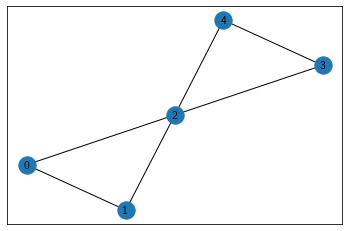

In [2]:
V = np.arange(0,5,1)
E = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)

In [3]:
from qaoa import *

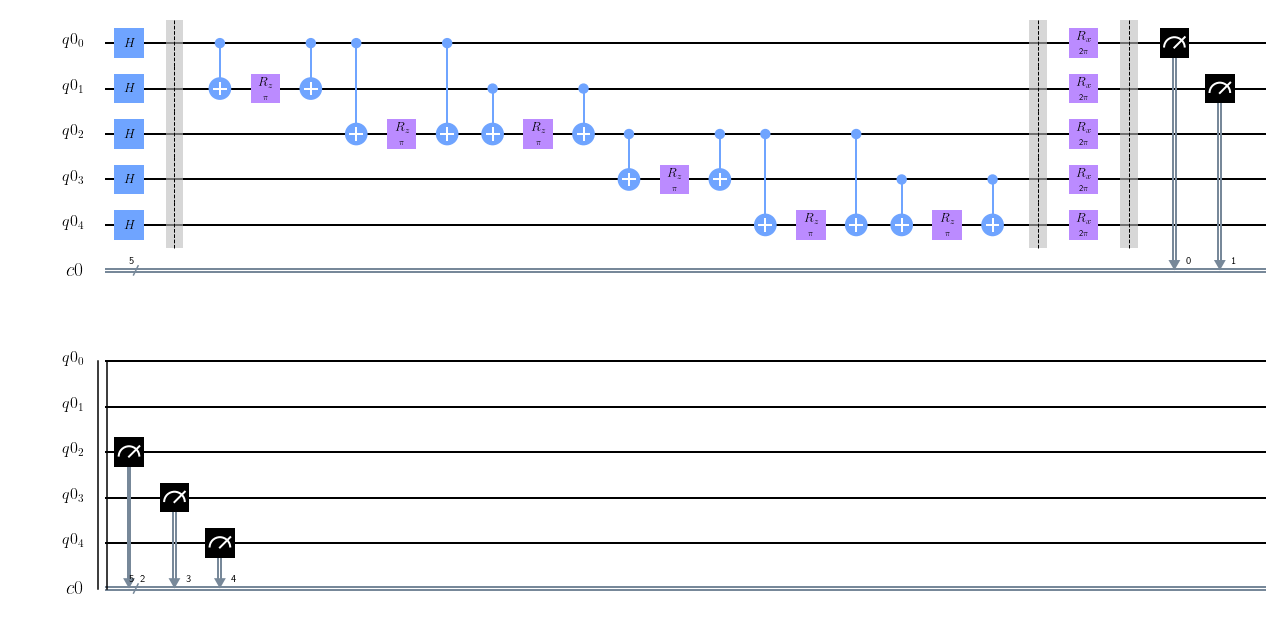

In [4]:
createCircuit_MaxCut(np.array((np.pi,np.pi)),G,1,1,True).draw(output='mpl')

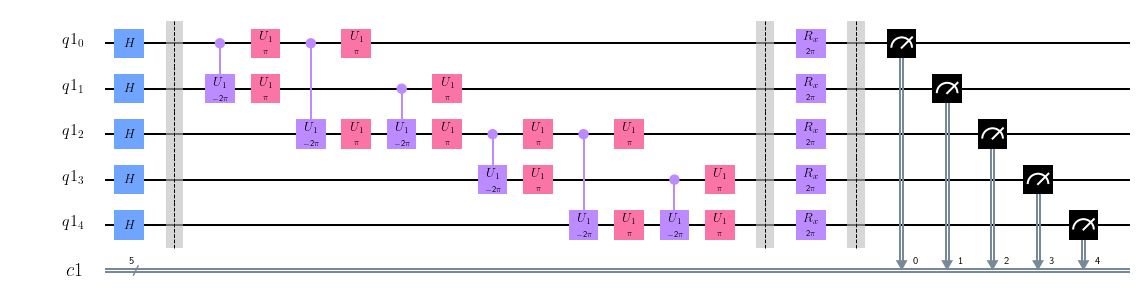

In [5]:
createCircuit_MaxCut(np.array((np.pi,np.pi)),G,1,2,True).draw(output='mpl')

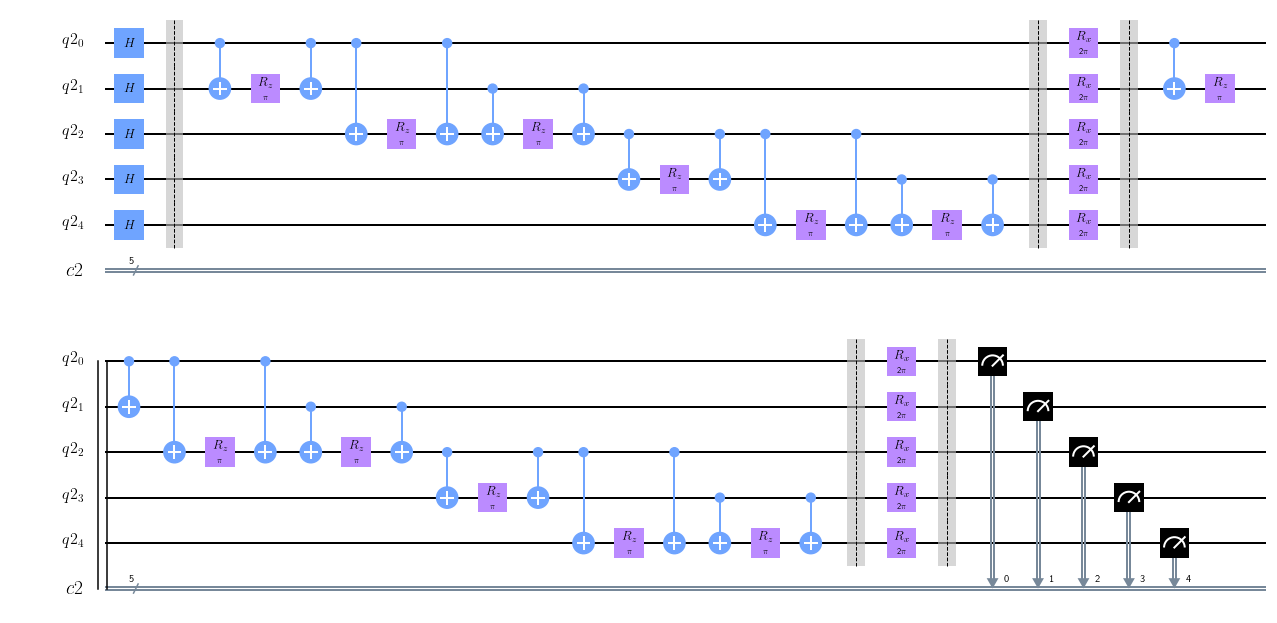

In [6]:
createCircuit_MaxCut(np.array((np.pi,np.pi,np.pi,np.pi)),G,2,1,True).draw(output='mpl')

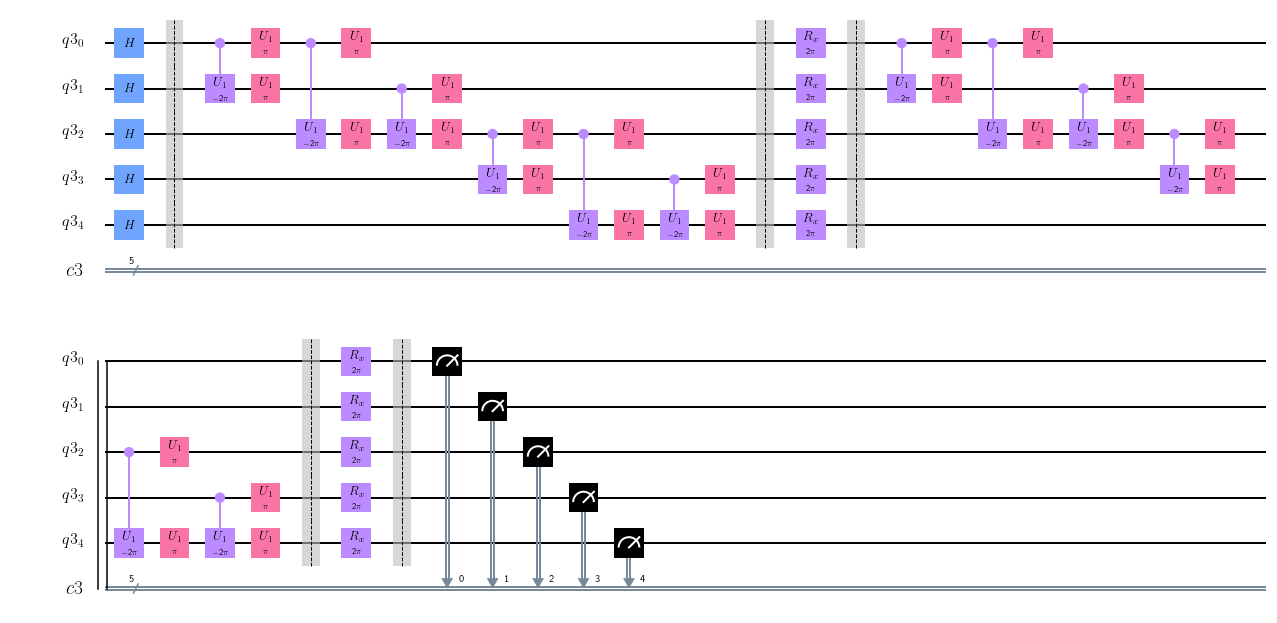

In [7]:
createCircuit_MaxCut(np.array((np.pi,np.pi,np.pi,np.pi)),G,2,2,True).draw(output='mpl')

In [68]:
cost,maximum,solutions=listcosts_MaxCut(G)
cost, maximum, solutions

({'00000': 0.0,
  '00001': 2.0,
  '00010': 2.0,
  '00011': 2.0,
  '00100': 4.0,
  '00101': 4.0,
  '00110': 4.0,
  '00111': 2.0,
  '01000': 2.0,
  '01001': 4.0,
  '01010': 4.0,
  '01011': 4.0,
  '01100': 4.0,
  '01101': 4.0,
  '01110': 4.0,
  '01111': 2.0,
  '10000': 2.0,
  '10001': 4.0,
  '10010': 4.0,
  '10011': 4.0,
  '10100': 4.0,
  '10101': 4.0,
  '10110': 4.0,
  '10111': 2.0,
  '11000': 2.0,
  '11001': 4.0,
  '11010': 4.0,
  '11011': 4.0,
  '11100': 2.0,
  '11101': 2.0,
  '11110': 2.0,
  '11111': 0.0},
 4.0,
 ['00100',
  '00101',
  '00110',
  '01001',
  '01010',
  '01011',
  '01100',
  '01101',
  '01110',
  '10001',
  '10010',
  '10011',
  '10100',
  '10101',
  '10110',
  '11001',
  '11010',
  '11011'])

In [69]:
ideal_solutions_counts={}
for key in solutions:
    ideal_solutions_counts[str(key)] = 100

In [9]:
def expectationValue(data,G):
    E=[]
    V = list(G.nodes)
    num_qubits = len(V)
    for item in range(0,len(data.results)):
        shots = data.results[item].shots
        counts = data.results[item].data.counts
        E.append(0)
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            binstring="{0:b}".format(int(key,0)).zfill(num_qubits)
            y=[int(i) for i in binstring]
            E[item] += cost_MaxCut(y,G)*c/shots
    return E

In [10]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [11]:
circuits=[]
n=32
for beta in np.linspace(-np.pi/2,np.pi,n):
    for gamma in np.linspace(-np.pi/2,np.pi,n):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,1))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v1 = -np.array(expectationValue(job_sim.result(),G))

In [12]:
circuits=[]
n=32
for beta in np.linspace(-np.pi/2,np.pi,n):
    for gamma in np.linspace(-np.pi/2,np.pi,n):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,2))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v2 = -np.array(expectationValue(job_sim.result(),G))

In [13]:
from scipy import optimize as opt

In [70]:
def getval(x, backend=backend_sim, depth=1, version=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val=expectationValue(j.result(),G)
    global it, values, gamma, beta
    #print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

def getvalJac(x, backend=backend_sim, depth=1, version=1, noisemodel=None):
    if depth>1:
        raise ValueError('depth>1 not supported!')
    j = execute(createCircuit_MaxCut(x,G,depth,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    delta=0.1
    x0=x
    x0[0]+=delta
    j0 = execute(createCircuit_MaxCut(x0,G,depth,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    x1=x
    x1[1]+=delta
    j1 = execute(createCircuit_MaxCut(x1,G,depth,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val=-expectationValue(j.result(),G)[0]
    val0=-expectationValue(j0.result(),G)[0]
    val1=-expectationValue(j1.result(),G)[0]
    d0=(val0-val)/delta
    d1=(val1-val)/delta
    de=1.#np.sqrt(d0*d0+d1*d1)
    #print(d0,d1)
    return np.array((d0/de,d1/de))

In [15]:
import sys
sys.path.append('../')

from noisyopt.noisyopt import minimizeCompass

In [18]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.7,0.25)

bounds = [[0,np.pi/2], [0, np.pi/2]]
x0 = np.array(xin)
out = minimizeCompass(getval, bounds=bounds, x0=x0, deltatol=0.1, paired=False)

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,n),interpolation='bicubic',origin='lower',extent=[-np.pi/2,np.pi,-np.pi/2,np.pi])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')
pl.plot(xin[0],xin[1],'or')
print(out.x)

j = execute(createCircuit_MaxCut(out.x,G,1,version), backend_sim, shots=1024*2*2*2)
plot_histogram(j.result().get_counts())

KeyboardInterrupt: 

0.224609375 3.90869140625
-0.146484375 1.66259765625
-0.48583984375 1.46240234375
-1.0986328125 -0.67138671875
-0.7177734375 -0.64453125
-0.7666015625 -0.31494140625
         Current function value: -1.766602
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 6
         Hessian evaluations: 0
[0.9  0.45]


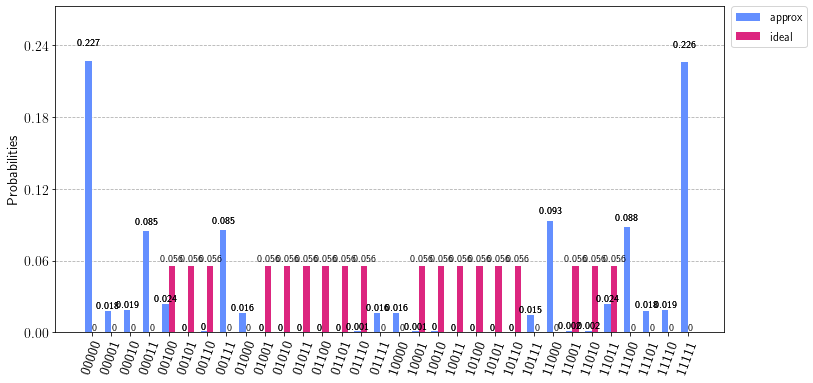

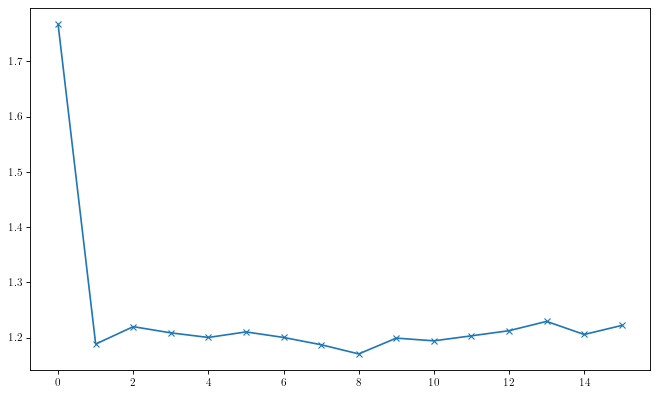

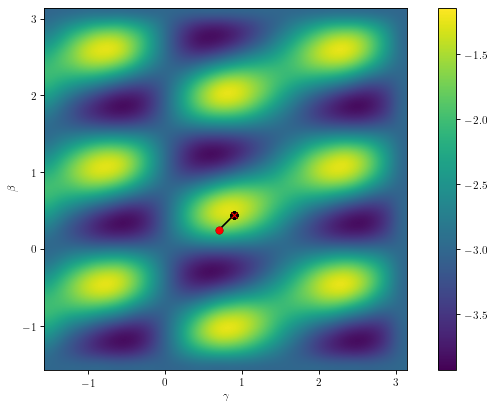

In [64]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.7,0.25)
out=opt.minimize(getval, x0=xin, method='Newton-CG', jac=getvalJac,\
                 #args=(backend_sim,1,version,None),\
             options={'disp': True})

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,n),interpolation='bicubic',origin='lower',extent=[-np.pi/2,np.pi,-np.pi/2,np.pi])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')
pl.plot(xin[0],xin[1],'or')
print(out.x)

j = execute(createCircuit_MaxCut(out.x,G,1,version), backend_sim, shots=1024*2*2*2)
plot_histogram([j.result().get_counts(),ideal_solutions_counts], figsize=(12, 6), legend=['approx','ideal'])

0.3466796875 3.8818359375
1.4013671875 -3.7255859375
0.390625 3.62548828125
1.0009765625 -0.5224609375
-2.07275390625 -0.7666015625
0.72265625 -0.9375
-0.4541015625 -2.13623046875
0.54443359375 -1.34033203125
0.4052734375 -1.20361328125
0.32470703125 -1.01806640625
-0.3271484375 0.234375
0.7177734375 -1.21337890625
0.59814453125 -1.15234375
0.3564453125 -1.2255859375
0.35888671875 -0.751953125
-0.0439453125 -0.22705078125
-0.2392578125 3.76708984375
-0.2490234375 0.34912109375
-0.31005859375 0.0244140625
-0.263671875 0.283203125
-0.20751953125 0.244140625
-0.2587890625 0.0732421875
0.263671875 2.81005859375
0.009765625 1.3134765625
-0.1904296875 0.32958984375
-0.1513671875 0.99365234375
-0.17822265625 0.66162109375
-0.09033203125 0.89111328125
-0.029296875 1.123046875
0.0244140625 1.0009765625
-0.04150390625 0.91064453125
-0.01220703125 1.1181640625
0.009765625 0.93017578125
-0.04150390625 0.888671875
-0.146484375 0.8544921875
-0.15380859375 0.60302734375
-0.16357421875 0.4150390625
  

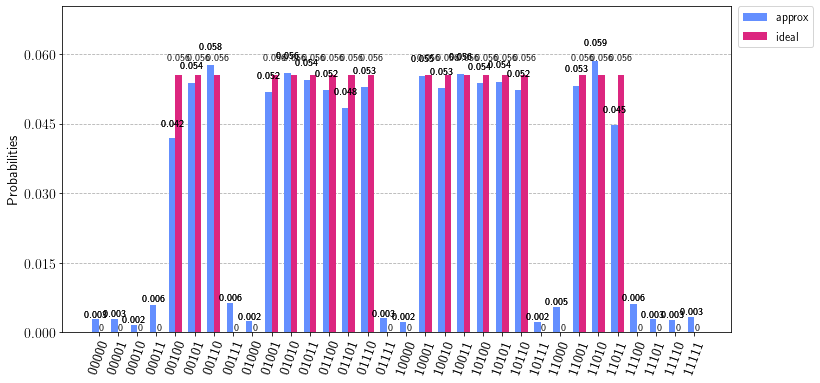

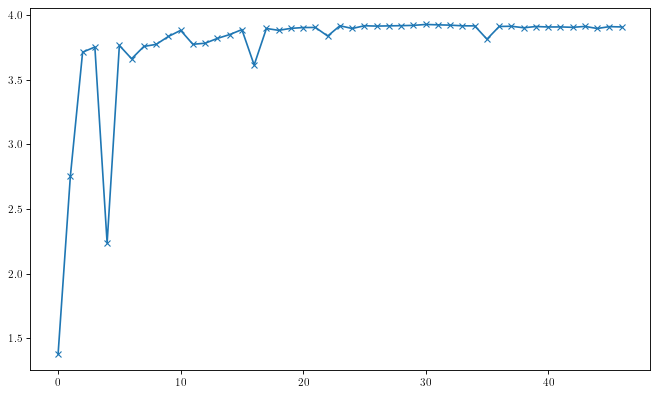

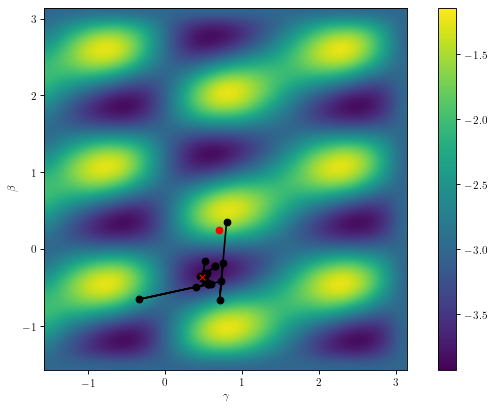

In [65]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.7,0.25)
out=opt.minimize(getval, x0=xin, method='CG', jac=getvalJac,\
                 #args=(backend_sim,1,version,None),\
             options={'disp': True})

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,n),interpolation='bicubic',origin='lower',extent=[-np.pi/2,np.pi,-np.pi/2,np.pi])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')
pl.plot(xin[0],xin[1],'or')
print(out.x)

j = execute(createCircuit_MaxCut(out.x,G,1,version), backend_sim, shots=1024*2*2*2)

plot_histogram([j.result().get_counts(),ideal_solutions_counts], figsize=(12, 6), legend=['approx','ideal'])

Optimization terminated successfully.
         Current function value: -3.083496
         Iterations: 18
         Function evaluations: 40


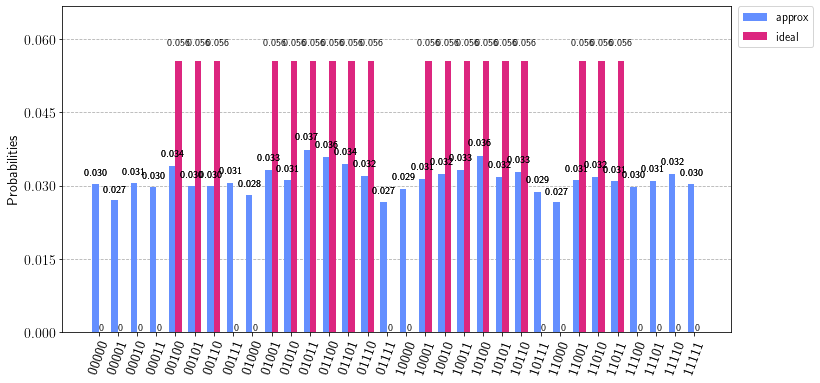

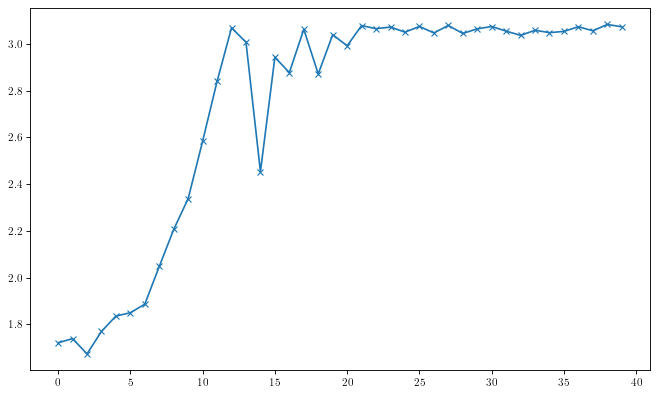

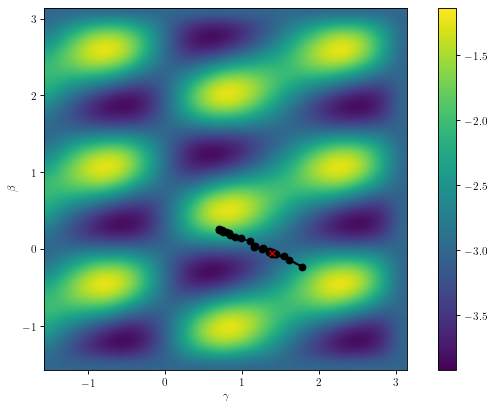

In [66]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.7,0.25)
out=opt.minimize(getval, x0=xin, method='Nelder-Mead',\
                 #args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v2).reshape(n,n),interpolation='bicubic',origin='lower',extent=[-np.pi/2,np.pi,-np.pi/2,np.pi])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')

j = execute(createCircuit_MaxCut(out.x,G,1,version), backend_sim, shots=1024*2*2*2)

plot_histogram([j.result().get_counts(),ideal_solutions_counts], figsize=(12, 6), legend=['approx','ideal'])